# MITgcm Example 

xgcm is developed in close coordination with the [xmitgcm](http://xmitgcm.readthedocs.io/) package.
The metadata in datasets constructed by xmitgcm should always be compatible with xgcm's expectations.
xmitgcm is necessary for reading MITgcm's binary MDS file format.
However, for this example, the MDS files have already been converted and saved as netCDF.

Below are some example of how to make calculations on mitgcm-style datasets using xgcm.

First we import xarray and xgcm:

In [1]:
import xarray as xr
import numpy as np
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

Now we open the example dataset which is stored in a [zenodo archive](https://zenodo.org/record/4421428#.X_XP7y1h3x9).

In [2]:
# download the data
import urllib.request
import shutil

url = 'https://zenodo.org/record/4421428/files/'
file_name = 'mitgcm_example_dataset_v2.nc'
with urllib.request.urlopen(url + file_name) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    
# open the data
ds = xr.open_dataset(file_name)
ds

<xarray.Dataset>
Dimensions:  (XC: 90, XG: 90, YC: 40, YG: 40, Z: 15, Zl: 15, time: 1)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
    maskC    (Z, YC, XC) bool ...
    dyC      (YG, XC) float32 ...
    hFacC    (Z, YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    hFacS    (Z, YG, XC) float32 ...
    Depth    (YC, XC) float32 ...
  * YG       (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
  * Z        (Z) float32 -25.0 -85.0 -170.0 ... -3.575e+03 -4.19e+03 -4.855e+03
    PHrefC   (Z) float32 ...
    dyG      (YC, XG) float32 ...
    rAw      (YC, XG) float32 ...
    drF      (Z) float32 ...
  * YC       (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 ... 66.0 70.0 74.0 78.0
    dxG      (YG, XC) float32 ...
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0
    iter     (time) int64 ...
    maskW    (Z, YC, XG) bool ...
  * Zl       (Zl) float32 0.0 -50.0 -120.0 ... -3.28e+03 -3.87e+03 -4.51e+03
    rAs      (YG, XC) float32 ...
    rAz      (YG, XG) float32 ...
    maskS    (Z, YG, XC) bool ...
    dxC      (YC, XG) float32 ...
    hFacW    (Z, YC, XG) float32 ...
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 ... 346.0 350.0 354.0 358.0
Data variables:
    UVEL     (time, Z, YC, XG) float32 ...
    VVEL     (time, Z, YG, XC) float32 ...
    WVEL     (time, Zl, YC, XC) float32 ...
    SALT     (time, Z, YC, XC) float32 ...
    THETA    (time, Z, YC, XC) float32 ...
    PH       (time, Z, YC, XC) float32 ...
    Eta      (time, YC, XC) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(extra_metadata=None, ll...

### Creating the grid object

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [3]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
Y Axis (periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

We see that xgcm identified five different axes: X (longitude), Y (latitude), Z (depth),  T (time), and 1RHO (the axis generated by the output of the LAYERS package).

## Velocity Gradients

The gradients of the velocity field can be decomposed  as divergence, vorticity, and strain. Below we use xgcm to compute the velocity gradients of the horizontal flow.

### Divergence

The divergence of the horizontal flow is is expressed as

$$ \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} $$


In discrete form, using [MITgcm notation](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#horizontal-divergence), the formula for the divergence on C-grid is

$$ \frac{1}{A_c h_c} ( \delta_i \Delta y_g h_w u + \delta_j \Delta x_g h_s v ) $$

The `UVEL`, `dyG` and `hFacW` DataArrays are defined on the U-points, which are on the left points of the X-axis (`XG`), while the `VVEL`, `dxG` and `hFacS` DataArrays are defined on V-points, which are the left point of the Y -axis (`YG`).

In [4]:
display(ds.UVEL.dims)
display(ds.VVEL.dims)

('time', 'Z', 'YC', 'XG')

('time', 'Z', 'YG', 'XC')

In [5]:
print(ds.UVEL.dims[2:] == ds.dyG.dims == ds.hFacW.dims[1:])
print(ds.VVEL.dims[2:] == ds.dxG.dims == ds.hFacS.dims[1:])

True
True


Now comes the xgcm magic: we take the diff along both axes and divide by the cell area element to find the divergence of the horizontal flow. Note how this new variable is at the cell center point.

In [6]:
div_uv = (grid.diff(ds.UVEL * ds.dyG * ds.hFacW, 'X') + grid.diff(ds.VVEL * ds.dxG * ds.hFacS, 'Y')) / (ds.rA * ds.hFacC)
div_uv.dims

('time', 'Z', 'YC', 'XC')

We plot this near the surface and observe the expected patern of divergence at the equator and in the subpolar regions, and convergence in the subtropical gyres.

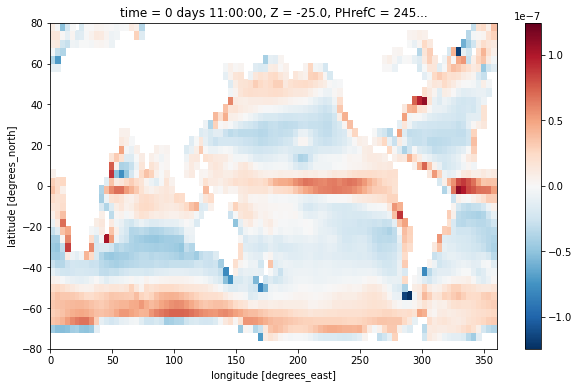

In [7]:
div_uv[0, 0].plot()

### Vorticity

The vertical component of the vorticity is a fundamental quantity of interest in ocean circulation theory. It is defined as

$$ \zeta = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \ . $$

On the c-grid, a finite-volume representation is given by

$$ \zeta =  (- \delta_j \Delta x_c u + \delta_i \Delta y_c v ) / A_\zeta \ . $$

In xgcm, we calculate this quantity as

In [8]:
zeta = (-grid.diff(ds.UVEL * ds.dxC, 'Y') + grid.diff(ds.VVEL * ds.dyC, 'X'))/ds.rAz
zeta

<xarray.DataArray (time: 1, Z: 15, YG: 40, XG: 90)>
array([[[[-1.48332937e-08, -1.02609041e-08, -6.38644559e-09, ...,
          -2.02205257e-08, -2.36162538e-08, -2.21622898e-08],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.81209766e-08,  3.97684836e-08,  4.13142871e-08, ...,
           1.29681979e-07,  3.34656640e-08,  3.61909045e-08],
         ...,
         [ 4.37701573e-08,  9.16013079e-08, -2.54561030e-08, ...,
           1.26603963e-08, -6.90892721e-09,  5.01466104e-08],
         [ 6.99142433e-08,  3.79757061e-08,  6.82349199e-09, ...,
           6.06992998e-08,  6.45270646e-08,  4.38413430e-08],
         [ 5.32967235e-08,  3.35858523e-08,  7.44277244e-08, ...,
          -4.63408085e-08,  1.05465695e-07, -3.87492776e-08]],

        [[-5.91518168e-09, -5.92747895e-09, -4.68231898e-09, ...,
           4.79974616e-10, -5.15723109e-09, -8.35224956e-09],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.93285876e-08,  2.88299127e-08,  2.76142540e-08, ...,
           4.49574458e-08,  2.74702163e-08,  2.87617432e-08],
...
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
  * Z        (Z) float32 -25.0 -85.0 -170.0 ... -3.575e+03 -4.19e+03 -4.855e+03
  * YG       (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0
    rAz      (YG, XG) float32 3.433e+10 3.433e+10 ... 4.783e+10 4.783e+10

...which we can see is located at the `YG, XG` horizontal position (also commonly called the vorticity point).

We plot the vertical integral of this quantity, i.e. the barotropic vorticity:

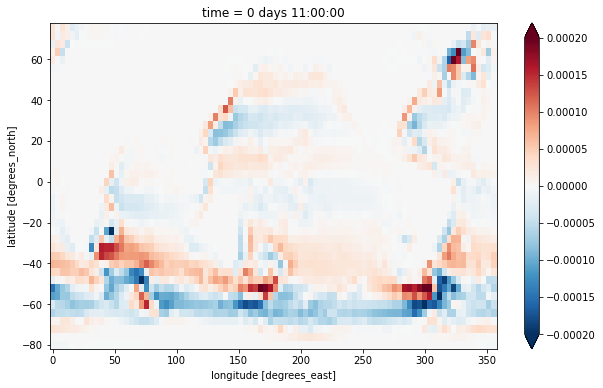

In [9]:
zeta_bt = (zeta * ds.drF).sum(dim='Z')
zeta_bt.plot(vmax=2e-4)

A different way to calculate the barotropic vorticity is to take the curl of the vertically integrated velocity.
This formulation also allows us to incorporate the $h$ factors representing partial cell thickness.

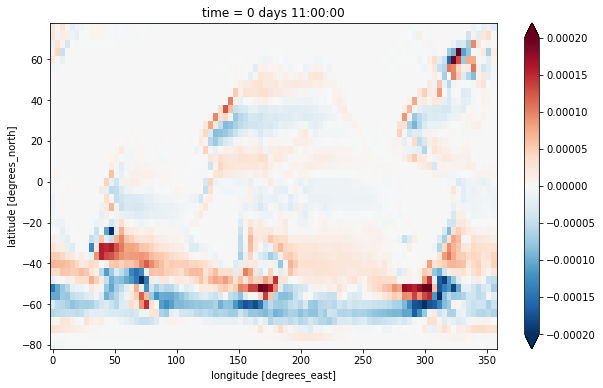

In [10]:
u_bt = (ds.UVEL * ds.hFacW * ds.drF).sum(dim='Z')
v_bt = (ds.VVEL * ds.hFacS * ds.drF).sum(dim='Z')
zeta_bt_alt = (-grid.diff(u_bt * ds.dxC, 'Y') + grid.diff(v_bt * ds.dyC, 'X'))/ds.rAz
zeta_bt_alt.plot(vmax=2e-4)

### Strain

Another interesting quantity is the horizontal strain, defined as

$$ s = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y} \ . $$

On the c-grid, a finite-volume representation is given by

$$ s =  (\delta_i \Delta y_g u - \delta_j \Delta x_g v ) / A_c \ . $$

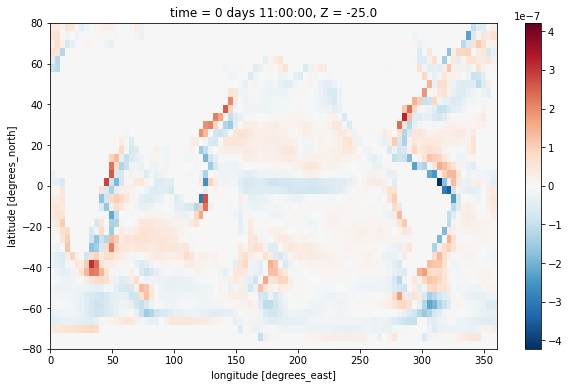

In [11]:
strain = (grid.diff(ds.UVEL * ds.dyG, 'X') - grid.diff(ds.VVEL * ds.dxG, 'Y')) / ds.rA
strain[0,0].plot()

## Barotropic Transport Streamfunction

We can use the barotropic velocity to calcuate the barotropic transport streamfunction, defined via

$$ u_{bt} = - \frac{\partial \Psi}{\partial y} \ , \ \ v_{bt} = \frac{\partial \Psi}{\partial x} \ .$$

We calculate this by integrating $u_{bt}$ along the Y axis using the grid object's `cumsum` method:

In [12]:
psi = grid.cumsum(-u_bt * ds.dyG, 'Y', boundary='fill')
psi

<xarray.DataArray (time: 1, YG: 40, XG: 90)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        ...,
        [-1.06634920e+08, -1.06666912e+08, -1.05922952e+08, ...,
         -1.07724152e+08, -1.07341128e+08, -1.06941400e+08],
        [-1.07050680e+08, -1.06612056e+08, -1.06356232e+08, ...,
         -1.07048232e+08, -1.07335792e+08, -1.07102304e+08],
        [-1.05933672e+08, -1.05922800e+08, -1.05856504e+08, ...,
         -1.05376272e+08, -1.05493376e+08, -1.05632128e+08]]],
      dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
  * YG       (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0

We see that xgcm automatically shifted the Y-axis position from center (YC) to left (YG) during the cumsum operation.

We convert to sverdrups and plot with a contour plot.

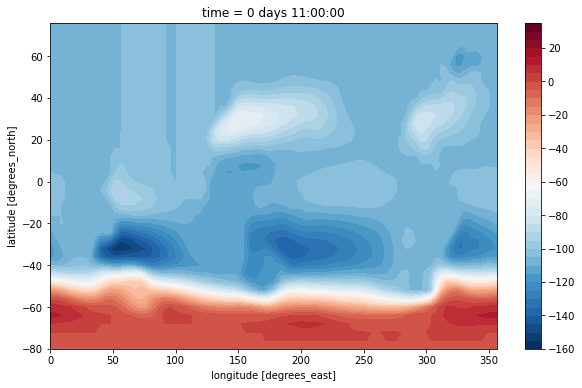

In [13]:
(psi[0] / 1e6).plot.contourf(levels=np.arange(-160, 40, 5))

This doesn't look nice because it lacks a suitable land mask. The dataset has no mask provided for the vorticity point. But we can build one with xgcm!

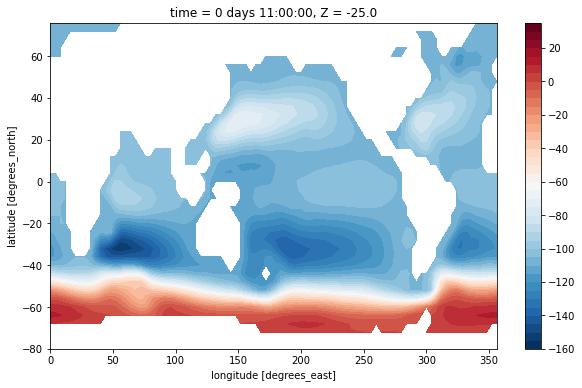

In [14]:
maskZ = grid.interp(ds.hFacS, 'X')
(psi[0] / 1e6).where(maskZ[0]).plot.contourf(levels=np.arange(-160, 40, 5))

## Kinetic Energy

Finally, we plot the kinetic energy $1/2 (u^2 + v^2)$ by interpoloting both quantities the cell center point.

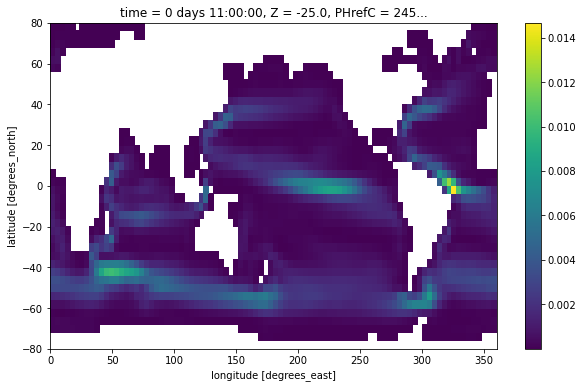

In [15]:
ke = 0.5*(grid.interp((ds.UVEL*ds.hFacW)**2, 'X') + grid.interp((ds.VVEL*ds.hFacS)**2, 'Y'))
ke[0,0].where(ds.maskC[0]).plot()